#1 Imports

In [2]:
!pip install Spotipy
!pip install kneed

In [3]:
import pandas as pd
import numpy as np

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#import spotipy.oauth2 as oauth2
#import spotipy.util as util

from IPython.display import clear_output
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix

from sklearn.neighbors import  NearestNeighbors
from sklearn.cluster import KMeans

#2 Credentials


In [4]:
CLIENT_ID = '************'
CLIENT_SECRET = '************'
playlist_id = 'spotify:playlist:0KY6lRcsNYtf6pHPfXDkFN'

username = '************'
#market = ['US']
#redirect_uri='http://localhost:8080/callback/'


#scope = 'playlist-read-private,playlist-modify-private,playlist-modify-public'

In [5]:
credentials = SpotifyClientCredentials(client_id=CLIENT_ID,client_secret=CLIENT_SECRET,)

token = credentials.get_access_token()
#token = util.prompt_for_user_token(username, scope, CLIENT_ID, CLIENT_SECRET, redirect_uri) 

sp = spotipy.Spotify(auth=token)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.



In [6]:
'''from spotipy.oauth2 import SpotifyOAuth
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,
                                               client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                              redirect_uri=redirect_uri))'''

'from spotipy.oauth2 import SpotifyOAuth\nsp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,\n                                               client_id=CLIENT_ID,\n                                               client_secret=CLIENT_SECRET,\n                                              redirect_uri=redirect_uri))'

#3 Extract Spotify Data

In [7]:
uri,id,popularity,name,duration_ms,artist,year,album =[],[],[],[],[],[],[],[]
acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence = [],[],[],[],[],[],[],[],[],[],[],[]
artist_genre = []

a=0

playlist_tracks = []
offset=0

while True:
    results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
    playlist_tracks += results['items']
    if results['next'] is not None:
        offset += 100
    else:
        break


for track_meta in playlist_tracks:

  #Meta Data
  uri.append(track_meta['track']['uri'])
  id.append(track_meta['track']['id'])
  popularity.append(track_meta['track']['popularity'])
  name.append(track_meta['track']['name'])
  duration_ms.append(track_meta['track']['duration_ms'])
  artist.append(track_meta['track']['artists'][0]['name'])
  year.append(track_meta['track']['album']['release_date'])
  album.append(track_meta['track']['album']['name'])

  #Audio Features
  track_feature = sp.audio_features(track_meta['track']['uri'])[0]

  acousticness.append(track_feature['acousticness'])
  danceability.append(track_feature['danceability'])
  energy.append(track_feature['energy'])
  instrumentalness.append(track_feature['instrumentalness'])
  key.append(track_feature['key'])
  liveness.append(track_feature['liveness'])
  loudness.append(track_feature['loudness'])
  mode.append(track_feature['mode'])
  speechiness.append(track_feature['speechiness'])
  tempo.append(track_feature['tempo'])
  time_signature.append(track_feature['time_signature'])
  valence.append(track_feature['valence'])

  #Genre
  resultd = sp.search(track_meta['track']['artists'][0]['name'])
  try:
    trackd = resultd['tracks']['items'][0]
    artist_meta = sp.artist(trackd["artists"][0]["external_urls"]["spotify"])
    artist_genre.append(artist_meta["genres"])
  except:
    artist_genre.append([])
  finally:
    a = a+1
    clear_output()
    print(a)



4358


In [8]:
df = pd.DataFrame(list(zip(name,album,artist,year,popularity,duration_ms,uri,id,acousticness,danceability,energy,instrumentalness,
                           key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_genre)),
                  
                  columns=['name','album','artist','year','popularity','duration_ms','uri','id','acousticness','danceability','energy','instrumentalness',
                           'key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','artist_genre']
                  )

df['playlist'] = sp.user_playlist(username, playlist_id.split(':')[2])['name']



df = df.drop_duplicates(subset='id', keep="first")
df.reset_index(inplace=True,drop=True)

df.head(3)

,name,album,artist,year,popularity,duration_ms,uri,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_genre,playlist
0,Regnantem sempiterna,Officium,Anonymous,1994-09-01,32,336000,spotify:track:411arAWnCRhqjKMXoQzIhs,411arAWnCRhqjKMXoQzIhs,0.966,0.109,0.00874,0.0389,2,0.0701,-24.886,1,0.0421,81.663,3,0.0363,[florida rap],For Data Science
1,Main Theme,Ori and the Will of the Wisps (Original Soundt...,Gareth Coker,2020-03-10,50,116590,spotify:track:0BqVTj3PfExdgXUu4vq7tb,0BqVTj3PfExdgXUu4vq7tb,0.978,0.173,0.04530,0.7580,2,0.0785,-26.289,0,0.0342,94.374,4,0.0791,"[scorecore, soundtrack, video game music]",For Data Science
2,Elisa's Theme,The Shape Of Water (Original Motion Picture So...,Alexandre Desplat,2017-12-01,52,156466,spotify:track:0Cr1H8kCXN5qBAQCHYtVGu,0Cr1H8kCXN5qBAQCHYtVGu,0.988,0.447,0.16800,0.8040,10,0.0979,-17.865,1,0.0372,180.063,3,0.2720,"[french soundtrack, hollywood, soundtrack]",For Data Science


In [9]:
df.to_pickle('sp_df.pkl')    #to save the dataframe, df to 123.pkl
#df_store = pd.read_pickle('sp_df.pkl')

In [10]:
#df.to_csv('data_spotify.csv')

In [11]:
#df = pd.read_csv('/content/data_spotify.csv')

# 4 Feature Extraction

In [12]:
genre_list = []

for i in df['artist_genre']:
  for j in i:
    if j not in genre_list:
      genre_list.append(j)

In [13]:
print(len(genre_list))
print(pd.Series(genre_list).nunique())

910
910


In [14]:
list_of_row,row=[],[]

for i in df['artist_genre']:

  for j in genre_list:
    if j not in i:
      row.append(0)
    else:
      row.append(1)

  list_of_row.append(row)
  row=[]
      

In [15]:
print(len(list_of_row))
print(len(list_of_row[0]))

4335
910


In [16]:
df_genre = pd.DataFrame(list_of_row,columns=genre_list)
df_genre['id'] = df['id'].copy()
df_genre.head()

,florida rap,scorecore,soundtrack,video game music,french soundtrack,hollywood,new age,album rock,art rock,blues rock,classic rock,country rock,folk rock,hard rock,heartland rock,mellow gold,rock,soft rock,yacht rock,brazilian edm,deep euro house,electronica,german techno,microhouse,minimal techno,organic house,tech house,deep disco house,melodic techno,swiss house,deep techno,alternative dance,dance-punk,danish indie,experimental pop,new rave,nu disco,anime score,japanese soundtrack,touken ranbu,...,chamber orchestra,library music,nova mpb,panpipe,jazz guitar,smooth jazz,relaxative,italian electronica,rome indie,pop violin,english baroque,bardcore,coverchill,cedm,atmospheric post-rock,cinematic post-rock,ukrainian experimental,italian hip hop,trap italiana,lowercase,pinoy reggae,pinoy rock,latin viral pop,rap latina,austrian pop,indian fusion,mumbai indie,pakistani indie,indian lo-fi,indian folk,pop r&b,horror synth,british post-rock,cosmic post-rock,british orchestra,spanish electronic,japanese piano,j-ambient,lullaby,id
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411arAWnCRhqjKMXoQzIhs
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0BqVTj3PfExdgXUu4vq7tb
2,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0Cr1H8kCXN5qBAQCHYtVGu
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3KKMyuchlLrzsLNPy2bc5T
4,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3gx30zEcvzMBNxGbPOg1eO


In [17]:
display(df_genre.columns)

Index(['florida rap', 'scorecore', 'soundtrack', 'video game music',
       'french soundtrack', 'hollywood', 'new age', 'album rock', 'art rock',
       'blues rock',
       ...
       'pop r&b', 'horror synth', 'british post-rock', 'cosmic post-rock',
       'british orchestra', 'spanish electronic', 'japanese piano',
       'j-ambient', 'lullaby', 'id'],
      dtype='object', length=911)

In [18]:
#merge Dataframes

merged_df = pd.merge(df, df_genre, on='id')

In [19]:
merged_df.head(2)

,name,album,artist,year,popularity,duration_ms,uri,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_genre,playlist,florida rap,scorecore,soundtrack,video game music,french soundtrack,hollywood,new age,album rock,art rock,blues rock,classic rock,country rock,folk rock,hard rock,heartland rock,mellow gold,rock,soft rock,...,instrumental post-rock,chamber orchestra,library music,nova mpb,panpipe,jazz guitar,smooth jazz,relaxative,italian electronica,rome indie,pop violin,english baroque,bardcore,coverchill,cedm,atmospheric post-rock,cinematic post-rock,ukrainian experimental,italian hip hop,trap italiana,lowercase,pinoy reggae,pinoy rock,latin viral pop,rap latina,austrian pop,indian fusion,mumbai indie,pakistani indie,indian lo-fi,indian folk,pop r&b,horror synth,british post-rock,cosmic post-rock,british orchestra,spanish electronic,japanese piano,j-ambient,lullaby
0,Regnantem sempiterna,Officium,Anonymous,1994-09-01,32,336000,spotify:track:411arAWnCRhqjKMXoQzIhs,411arAWnCRhqjKMXoQzIhs,0.966,0.109,0.00874,0.0389,2,0.0701,-24.886,1,0.0421,81.663,3,0.0363,[florida rap],For Data Science,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Main Theme,Ori and the Will of the Wisps (Original Soundt...,Gareth Coker,2020-03-10,50,116590,spotify:track:0BqVTj3PfExdgXUu4vq7tb,0BqVTj3PfExdgXUu4vq7tb,0.978,0.173,0.04530,0.7580,2,0.0785,-26.289,0,0.0342,94.374,4,0.0791,"[scorecore, soundtrack, video game music]",For Data Science,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
'''# converting list data of genres to a single string
ll=[]
for i in df['artist_genre']:
  k=''
  for j in i:
    k=k+j
  ll.append(str(k))

df['artist_genre_new'] = pd.Series(ll)'''

"# converting list data of genres to a single string\nll=[]\nfor i in df['artist_genre']:\n  k=''\n  for j in i:\n    k=k+j\n  ll.append(str(k))\n\ndf['artist_genre_new'] = pd.Series(ll)"

In [21]:
'''#making genre features
import re

def lang(genre):
  if re.match(r"desi", genre) or re.match(r"bollywood", genre) or re.match(r"hindi", genre) or re.match(r"india", genre):
    return 1
  else:
    return 0'''

'#making genre features\nimport re\n\ndef lang(genre):\n  if re.match(r"desi", genre) or re.match(r"bollywood", genre) or re.match(r"hindi", genre) or re.match(r"india", genre):\n    return 1\n  else:\n    return 0'

In [22]:
'''df['hindi'] = df['artist_genre_new'].apply( lambda x: lang(x) )
df.hindi.plot()'''

"df['hindi'] = df['artist_genre_new'].apply( lambda x: lang(x) )\ndf.hindi.plot()"

#6 Clustering & EDA

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3773 entries, 0 to 3772
Columns: 927 entries, name to british orchestra
dtypes: float64(9), int64(910), object(8)
memory usage: 26.7+ MB


Optimal number of clusters 8


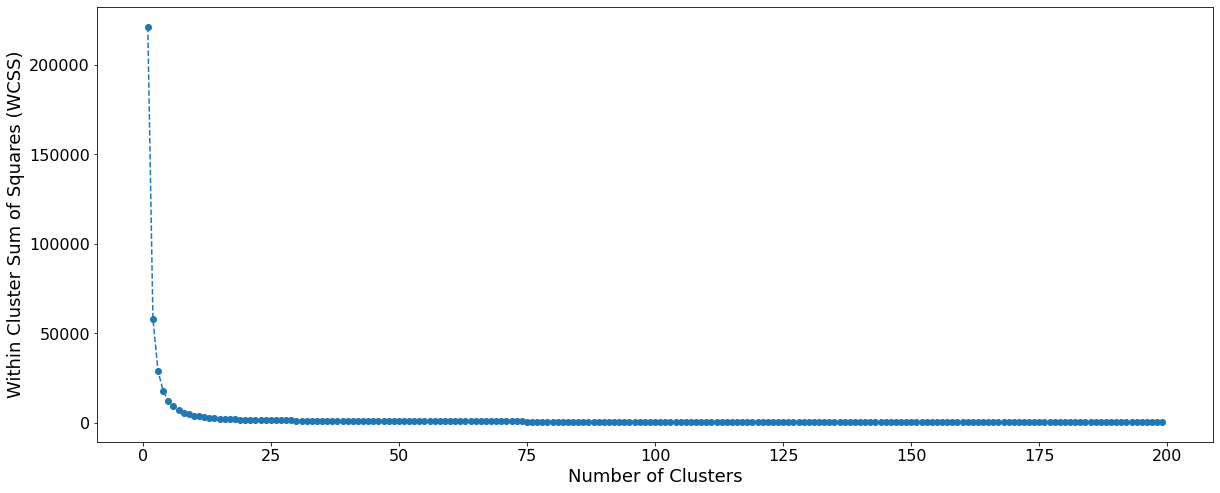

In [ ]:


# get within cluster sum of squares for each value of k
wcss = []
max_clusters = 200
for i in range(1, max_clusters):
    kmeans_cluster = KMeans(i, init='k-means++', random_state=42)
    kmeans_cluster.fit(df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']])
    wcss.append(kmeans_cluster.inertia_)
      
# programmatically locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)
    
# visualize the curve in order to locate the elbow
fig = plt.figure(figsize=(20,8))
plt.plot(range(1, max_clusters), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42,)
kmeans.fit(df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
scaled_df = df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']].copy()


scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(scaled_df) 
scaled_df.loc[:,:] = scaled_values


scaled_df['Cluster'] = kmeans.labels_

In [ ]:


fig = go.Figure()

angles = list(scaled_df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']].columns)
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = scaled_df[scaled_df['Cluster'] == i]
    data = [np.mean(subset[col]) for col in subset[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']].columns]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True,template='plotly_dark'
        )
fig.show()

In [ ]:
scaled_df['name'] = df['name']
scaled_df[scaled_df['Cluster'] == 5]['name']

3                                      Earth Heal
15      "We're Not Programs, GERTY, We're People"
780                         The One That Got Away
784                           Valjean's Soliloquy
797                                         Stars
                          ...                    
3719                                      Opening
3720                                     Briefing
3724                                         Orbs
3725                             Underground Lake
3750                                        Older
Name: name, Length: 278, dtype: object

#5 Data Pre processing

##5.1 Vault

In [23]:
data1 = df.copy()

##5.2 pre processsing

In [24]:
#List of columns to be used as features
list1=['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
list2=list(df_genre.columns)
dataset = merged_df[list1+list2].copy()
#set index
dataset.set_index('id',drop=True,inplace=True)

In [25]:
dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,florida rap,scorecore,soundtrack,video game music,french soundtrack,hollywood,new age,album rock,art rock,blues rock,classic rock,country rock,folk rock,hard rock,heartland rock,mellow gold,rock,soft rock,yacht rock,brazilian edm,deep euro house,electronica,german techno,microhouse,minimal techno,organic house,tech house,deep disco house,melodic techno,swiss house,deep techno,...,instrumental post-rock,chamber orchestra,library music,nova mpb,panpipe,jazz guitar,smooth jazz,relaxative,italian electronica,rome indie,pop violin,english baroque,bardcore,coverchill,cedm,atmospheric post-rock,cinematic post-rock,ukrainian experimental,italian hip hop,trap italiana,lowercase,pinoy reggae,pinoy rock,latin viral pop,rap latina,austrian pop,indian fusion,mumbai indie,pakistani indie,indian lo-fi,indian folk,pop r&b,horror synth,british post-rock,cosmic post-rock,british orchestra,spanish electronic,japanese piano,j-ambient,lullaby
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
411arAWnCRhqjKMXoQzIhs,0.966,0.109,0.00874,0.0389,0.0701,-24.886,0.0421,81.663,0.0363,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0BqVTj3PfExdgXUu4vq7tb,0.978,0.173,0.04530,0.7580,0.0785,-26.289,0.0342,94.374,0.0791,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0Cr1H8kCXN5qBAQCHYtVGu,0.988,0.447,0.16800,0.8040,0.0979,-17.865,0.0372,180.063,0.2720,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3KKMyuchlLrzsLNPy2bc5T,0.989,0.107,0.10300,0.8860,0.0792,-19.617,0.0410,69.084,0.0519,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3gx30zEcvzMBNxGbPOg1eO,0.908,0.377,0.26400,0.0276,0.0973,-14.659,0.0313,74.745,0.0719,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
#create sparse matrix
dataset_matrix = csr_matrix(dataset.values)

In [27]:
dataset

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,florida rap,scorecore,soundtrack,video game music,french soundtrack,hollywood,new age,album rock,art rock,blues rock,classic rock,country rock,folk rock,hard rock,heartland rock,mellow gold,rock,soft rock,yacht rock,brazilian edm,deep euro house,electronica,german techno,microhouse,minimal techno,organic house,tech house,deep disco house,melodic techno,swiss house,deep techno,...,instrumental post-rock,chamber orchestra,library music,nova mpb,panpipe,jazz guitar,smooth jazz,relaxative,italian electronica,rome indie,pop violin,english baroque,bardcore,coverchill,cedm,atmospheric post-rock,cinematic post-rock,ukrainian experimental,italian hip hop,trap italiana,lowercase,pinoy reggae,pinoy rock,latin viral pop,rap latina,austrian pop,indian fusion,mumbai indie,pakistani indie,indian lo-fi,indian folk,pop r&b,horror synth,british post-rock,cosmic post-rock,british orchestra,spanish electronic,japanese piano,j-ambient,lullaby
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
411arAWnCRhqjKMXoQzIhs,0.966,0.109,0.00874,0.0389,0.0701,-24.886,0.0421,81.663,0.0363,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0BqVTj3PfExdgXUu4vq7tb,0.978,0.173,0.04530,0.7580,0.0785,-26.289,0.0342,94.374,0.0791,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0Cr1H8kCXN5qBAQCHYtVGu,0.988,0.447,0.16800,0.8040,0.0979,-17.865,0.0372,180.063,0.2720,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3KKMyuchlLrzsLNPy2bc5T,0.989,0.107,0.10300,0.8860,0.0792,-19.617,0.0410,69.084,0.0519,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3gx30zEcvzMBNxGbPOg1eO,0.908,0.377,0.26400,0.0276,0.0973,-14.659,0.0313,74.745,0.0719,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2W2fS1W731q3EomZSZEsnI,0.990,0.359,0.13200,0.9090,0.1090,-24.722,0.0325,104.151,0.1330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75LbLUHpRWfMLsBgVohKdp,0.996,0.322,0.05480,0.9510,0.0883,-25.560,0.0607,175.619,0.2710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3rkfPXBvaNLZNzwrWZ0Dmd,0.996,0.446,0.00280,0.9320,0.1130,-35.118,0.0573,68.965,0.2080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#7 NN

In [28]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(dataset_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [34]:
search_uri = 'spotify:track:6F9VK2ePnnFP5FiyGoQwJ5'
query_index = df[df['uri']==search_uri].index.values[0]

distances, indices = model_knn.kneighbors(dataset.iloc[query_index,:].values.reshape(1,-1),n_neighbors=20)

for i in range(0,len(distances.flatten())):
#  if distances.flatten()[i] <= 0.0002:

    if i == 0:
      print('Recommendations for {0}:\n'.format(df[df['id']==str(dataset.index[query_index])]['name'].values[0]))
    else:
      print('{0} : {1} by {3}, with distance of {2}'.format(i,
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['name'].values[0],
                                                     distances.flatten()[i],
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['artist'].values[0]
                                                     ))


Recommendations for Leniency:

1 : Airborne by Maria Novotna, with distance of 2.06734876517789e-06
2 : Sometimes by Crimson Memoirs, with distance of 2.519648796162066e-06
3 : Alla fine insieme (Together at Last) by Guiseppe Amilcare, with distance of 9.570239936307345e-06
4 : Crossing the Danube by Marcel Pokorný, with distance of 1.0172523828066993e-05
5 : Tanken för oss vidare by Melvin Norberg, with distance of 1.1312100315130635e-05
6 : Sail by Roman Jensen, with distance of 1.1998403632640375e-05
7 : Kebnekajse by Karin Borg, with distance of 2.1676646513535403e-05
8 : Toruń by Juliusz Borkowska, with distance of 2.506268426805125e-05
9 : Senza tentazioni, senza onore by Domenico Cattaneo, with distance of 2.540302723375021e-05
10 : L'infinito by Gabriele da Lentini, with distance of 2.5530789230288065e-05
11 : Lacrimosa by Lucas Vendrai, with distance of 3.2765192274131216e-05
12 : La gatta frettolosa fece i gattini ciechi by Domenico Cattaneo, with distance of 3.87511870989509

In [71]:
  merged_df[merged_df['name']=='Equanimity']['uri'].values

array(['spotify:track:2AbyBaX0bEfKoF0FVa0bz9',
       'spotify:track:3M5lUdfPdQWrqLYU4x8KGg'], dtype=object)

#7 Generate Playlist

In [ ]:
song_list=[]
for i in range(0,len(distances.flatten())):
  song_list.append(df[df['id']==str(dataset.index[indices.flatten()[i]])]['uri'].values[0])

In [ ]:
distances

In [ ]:
song_list

In [ ]:
for i in range(0,len(distances.flatten())):
    recom = sp.user_playlist_create(username,
            'Recommendation for'+str(df[df['id']==str(dataset.index[query_index])]['name'].values[0]),
             public=True,
             collaborative=False,
             description='This Playlist has been created using Nearest Neigbor algorithm')
    

    new_playlist_id = recom['id']

    sp.playlist_add_items(new_playlist_id,song_list)
                          

'''    
    songs = list(df.loc[df['Cluster'] == i]['track_URI'])
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)'''